In [4]:
import os
from scipy.io import wavfile
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
!pip install python_speech_features
# Rename the class to avoid conflict with a module with the same name
class AudioConfig: # Renamed Config to AudioConfig
    def __init__(self,mode='conv', nfilt=26, nfeat=13, nfft=512, rate=16000):
        self.mode = mode
        self.nfilt = nfilt
        self.nfeat = nfeat
        self.nfft = nfft
        self.rate = rate
        self.step = int(rate/10)
from keras.layers import Conv2D, MaxPool2D, Flatten, LSTM
from keras.layers import Dropout, Dense, TimeDistributed
from keras.models import Sequential
from keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
from python_speech_features import mfcc
import pickle
from keras.callbacks import ModelCheckpoint
#from config import Config # This line is no longer needed

In [7]:
class Config:
    def __init__(self,mode='conv', nfilt=26, nfeat=13, nfft=512, rate=16000):
        self.mode = mode
        self.nfilt = nfilt
        self.nfeat = nfeat
        self.nfft = nfft
        self.rate = rate
        self.step = int(rate/10)

In [12]:
from google.colab import drive
drive.mount('/content/drive')
speech_df = pd.read_csv('/content/drive/My Drive/labproject/my-voice-amongsts-instruments.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
speech_df.set_index('fname', inplace=True)

In [15]:
for f in speech_df.index:
    rate, signal = wavfile.read('/content/drive/My Drive/labproject/clean/'+f)
    speech_df.at[f, 'length'] = signal.shape[0]/rate

In [16]:
classes = list(np.unique(speech_df.label))

In [17]:
class_dist = speech_df.groupby(['label'])['length'].mean()

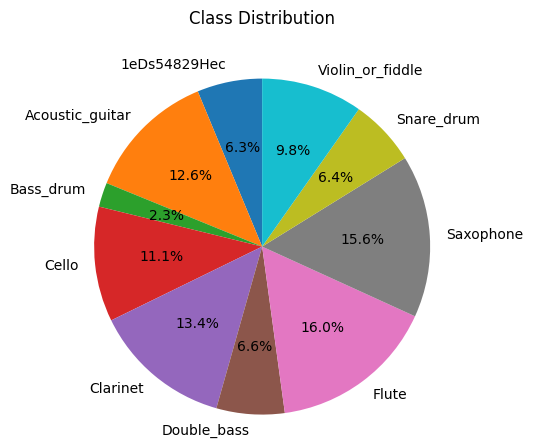

In [18]:
fig, ax = plt.subplots()
ax.set_title('Class Distribution', y=1.08)
ax.pie(class_dist, labels=class_dist.index, autopct='%1.1f%%',
       shadow=False, startangle=90)
ax.axis('equal')
plt.show()

In [19]:
n_samples = 2 * int(speech_df['length'].sum() / 0.1)
n_samples

26346

In [20]:
# Build a probability distribution
prob_dist = class_dist / class_dist.sum()
prob_dist

,length
label,
1eDs54829Hec,0.062578
Acoustic_guitar,0.125758
Bass_drum,0.023417
Cello,0.110618
Clarinet,0.133699
Double_bass,0.065532
Flute,0.160309
Saxophone,0.156332
Snare_drum,0.064152


In [21]:
# random sampling
choices = np.random.choice(class_dist.index, p=prob_dist)
choices

'Flute'

In [22]:
# Initialize the config
config = Config(mode='conv')

In [23]:
def build_rand_feat():
    X = []
    y = []
    _min, _max  =float('inf'), -float('inf')
    for _ in tqdm(range(n_samples)):
        rand_class = np.random.choice(class_dist.index,p=prob_dist)
        file = np.random.choice(speech_df[speech_df.label==rand_class].index)
        rate, wav = wavfile.read('clean/'+file)
        label = speech_df.at[file,'label']
        rand_index = np.random.randint(0,wav.shape[0] - config.step)
        sample = wav[rand_index:rand_index+config.step]
        X_sample = mfcc(sample,rate,numcep=config.nfeat,nfilt=config.nfilt,nfft=config.nfft).T

        _min = min(np.amin(X_sample), _min)
        _max = max(np.amax(X_sample), _max)

        X.append(X_sample if config.mode == 'conv' else X_sample.T)
        y.append(classes.index(label))

    X,y = np.array(X), np.array(y)
    X = (X - _min) / (_max - _min) # rescaling

    if config.mode == 'conv': # Building a convolution neural network
        X = X.reshape(X.shape[0],X.shape[1],X.shape[2],1)
    elif config.mode == 'time': # Build a recurrent neural network
        X = X.reshape(X.shape[0],X.shape[1],X.shape[2])

    y  = to_categorical(y, num_classes=10)

    return X, y

In [24]:
def get_conv_model():
    model = Sequential()
    model.add(Conv2D(16, (3,3), activation='relu', strides=(1,1), padding='same', input_shape=input_shape ))
    model.add(Conv2D(32, (3,3), activation='relu', strides=(1,1), padding='same'))
    model.add(Conv2D(64, (3,3), activation='relu', strides=(1,1), padding='same'))
    model.add(Conv2D(128, (3,3), activation='relu', strides=(1,1), padding='same'))
    model.add(MaxPool2D((2,2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(128,activation='relu'))
    model.add(Dense(64,activation='relu'))
    model.add(Dense(10,activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
    return model

In [27]:
def get_recurrent_model():
    # Shape of data for RNN is n,time,feat
    model = Sequential()
    model.add(LSTM(128, return_sequences=True,input_shape=input_shape))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(64,activation='relu')))
    model.add(TimeDistributed(Dense(32,activation='relu')))
    model.add(TimeDistributed(Dense(16,activation='relu')))
    model.add(TimeDistributed(Dense(8,activation='relu')))
    model.add(Flatten())
    model.add(Dense(10,activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
    return model

In [28]:
def build_rand_feat():
    X = []
    y = []
    _min, _max  =float('inf'), -float('inf')
    for _ in tqdm(range(n_samples)):
        rand_class = np.random.choice(class_dist.index,p=prob_dist)
        file = np.random.choice(speech_df[speech_df.label==rand_class].index)
        # Updated the path to include the full path to the 'clean' directory
        rate, wav = wavfile.read('/content/drive/My Drive/labproject/clean/'+file)
        label = speech_df.at[file,'label']
        rand_index = np.random.randint(0,wav.shape[0] - config.step)
        sample = wav[rand_index:rand_index+config.step]
        X_sample = mfcc(sample,rate,numcep=config.nfeat,nfilt=config.nfilt,nfft=config.nfft).T

        _min = min(np.amin(X_sample), _min)
        _max = max(np.amax(X_sample), _max)

        X.append(X_sample if config.mode == 'conv' else X_sample.T)
        y.append(classes.index(label))

    X,y = np.array(X), np.array(y)
    X = (X - _min) / (_max - _min) # rescaling

    if config.mode == 'conv': # Building a convolution neural network
        X = X.reshape(X.shape[0],X.shape[1],X.shape[2],1)
    elif config.mode == 'time': # Build a recurrent neural network
        X = X.reshape(X.shape[0],X.shape[1],X.shape[2])

    y  = to_categorical(y, num_classes=10)

    return X, y

In [30]:
# Call build_rand_feat to generate X and y
X, y = build_rand_feat()

# Flatten y to create y_flat
y_flat = y.argmax(axis=1)  # Assuming 'y' is one-hot encoded, this gives class indices

# Now compute class_weight using y_flat
class_weight = compute_class_weight('balanced', np.unique(y_flat), y_flat)

100%|██████████| 26346/26346 [03:22<00:00, 129.97it/s]


TypeError: too many positional arguments

In [ ]:
model.fit(X,y,epochs=11,batch_size=32,shuffle=True,class_weight=class_weight)

W1026 02:21:47.695259 139910939060032 deprecation.py:323] From /usr/local/gcti/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/11
26350/26350 [==============================] - 61s 2ms/step - loss: 1.1462 - acc: 0.5941
Epoch 2/11
26350/26350 [==============================] - 58s 2ms/step - loss: 0.5907 - acc: 0.7983
Epoch 3/11
26350/26350 [==============================] - 57s 2ms/step - loss: 0.4244 - acc: 0.8563
Epoch 4/11
26350/26350 [==============================] - 58s 2ms/step - loss: 0.3369 - acc: 0.8875
Epoch 5/11
26350/26350 [==============================] - 58s 2ms/step - loss: 0.2790 - acc: 0.9049
Epoch 6/11
26350/26350 [==============================] - 58s 2ms/step - loss: 0.2471 - acc: 0.9165
Epoch 7/11
26350/26350 [==============================] - 57s 2ms/step - loss: 0.2138 - acc: 0.9271
Epoch 8/11
26350/26350 [==============================] - 58s 2ms/step - loss: 0.1923 - acc: 0.9361
Epoch 9/11
26350/26350 [==============================] - 192s 7ms/step - loss: 0.1845 - acc: 0.9366
Epoch 10/11
26350/26350 [==============================] - 58s 2ms/step - loss: 0.1581 - acc: 0.944